In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from fitting_functions.extra_lineshapes import magnon
from fitting_functions.extra_models import ParaMagnonModel, Zero2LinearModel
import lmfit
#, paramagnon, zero2Linear

#from fitting_functions.extra_lineshapes import magnon, paramagnon, zero2Linear

%matplotlib widget

<ErrorbarContainer object of 3 artists>

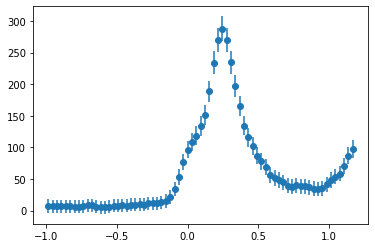

In [2]:
x, y = np.loadtxt('LSCO_30_LH_grazout.txt', unpack=True, skiprows=1)

choose = np.logical_and(x>-1.2, x<1)
x = x[choose] * -1
y = y[choose]
e = np.sqrt(y+100)

fig, ax = plt.subplots()
ax.errorbar(x, y, e, fmt='o')

[[Model]]
    (((Model(gaussian, prefix='el_') + Model(paramagnon, prefix='mag_')) + Model(zero2Linear, prefix='dd_')) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 71
    # variables        = 7
    chi-square         = 2867.15255
    reduced chi-square = 44.7992586
    Akaike info crit   = 276.586031
    Bayesian info crit = 292.424790
[[Variables]]
    el_sigma:       0.05095931 (fixed)
    el_center:      0 (fixed)
    el_amplitude:   8.65504171 +/- 0.54965420 (6.35%) (init = 1)
    mag_amplitude:  38.8186092 +/- 0.81841739 (2.11%) (init = 20)
    mag_center:     0.28116770 +/- 0.00230103 (0.82%) (init = 0.35)
    mag_sigma:      0.28615578 +/- 0.00949029 (3.32%) (init = 0.05)
    mag_res:        0.05095931 (fixed)
    mag_kBT:        0.00215425 (fixed)
    dd_grad:        310.224639 +/- 52.1294246 (16.80%) (init = 100)
    dd_sigma:       0.12 (fixed)
    dd_center:      0.92492627 +/- 0.03186021 (3.44%) 

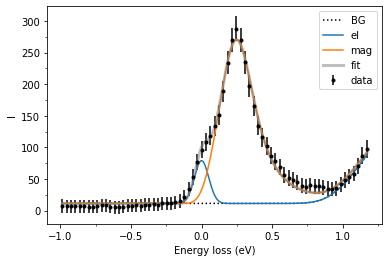

In [3]:
model = (lmfit.models.GaussianModel(prefix='el_') + ParaMagnonModel(prefix='mag_')
         + Zero2LinearModel(prefix='dd_') + lmfit.models.ConstantModel())
params = model.make_params()

fwhm =2*np.sqrt(2*np.log(2))
res = 0.12/fwhm
                    
params['el_center'].set(value=0, vary=False)
params['el_amplitude'].set(value=1)
params['el_sigma'].set(value=res, vary=False)

params['mag_center'].set(value=.35)
params['mag_sigma'].set(value=.05)
params['mag_amplitude'].set(value=20)


params['mag_res'].set(value=res, vary=False)
params['mag_kBT'].set(value=8.617e-5*25, vary=False)

params['dd_sigma'].set(value=0.12, vary=False)
params['dd_center'].set(value=1.)
params['dd_grad'].set(value=100)

params['c'].set(value=7.5)

result = model.fit(y, x=x, params=params)

fig, ax = plt.subplots()

x_fit = np.linspace(x.min(), x.max(), 1000)

components = result.eval_components(x=x_fit)
constant = components.pop('constant')
slope = components.pop('dd_')

BG = constant + slope

ax.plot(x_fit, BG, 'k:', label='BG')
for model_name, model_value in components.items():
    ax.plot(x_fit, model_value + BG, '-', label=model_name.strip('_'))

y_fit = result.eval(**result.best_values, x=x_fit)
ax.plot(x_fit, y_fit, color=[0.5]*3, label='fit', lw=3, alpha=0.5)
ax.errorbar(x, y, e, fmt='k.', label='data')

ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('I')
ax.legend()

ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

print(result.fit_report())